<a href="https://colab.research.google.com/github/invegat/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/DS_Unit_1_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

In [2]:
import regex
from requests import get
from contextlib import closing
import numpy as np
import pandas as pd
from scipy.stats import mode
column_names_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.names'
text = None
with closing(get(column_names_url, stream=True)) as resp:
    text = resp.content.decode('UTF-8')

stext = "Attribute Information:\n"
etext = "\n\n8.  Missing Attribute Values:"

ctext = text[text.index(stext) + len(stext):text.index(etext)]
r = regex.compile(r"(A\d{1,2})")
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
df = pd.read_csv(url, header=None, names=[name for name in r.findall(ctext)])
L = df.shape[0]
missing = []
df.head(20)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,00120,0,+
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,00360,0,+
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,00164,31285,+
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,00080,1349,+
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,00180,314,+
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,00052,1442,+


In [0]:
# df[~df.A1.isin(['a', 'b'])]

In [4]:
A1 = df.A1[df.A1.isin(['a', 'b'])]
missing.append(('A1', L - len(A1)))
print(type(df.A2[0]))
df['a1'] = df.A1.apply(lambda a: np.nan if a == '?' else (int(1) if a == 'a' else int(0)))
A2 = df.A2[df.A2 != '?']
missing.append(('A2', L - len(A2)))
# A2 = A2.apply(lambda a: float(a))
# mean = A2.mean()
df['a2'] = df.A2.apply(lambda a: np.nan if a == '?' else float(a))
df.head()

<class 'str'>


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,a1,a2
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+,0.0,30.83
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+,1.0,58.67
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+,1.0,24.50
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+,0.0,27.83
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+,0.0,20.17


In [5]:
A4 = df.A4[df.A4 != '?']
missing.append(('A4', L - len(A4)))
df['a4'] = df.A4.apply(lambda a: np.nan if a == '?' else a)
df[df.a4.isnull()]

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,a1,a2,a4
206,a,71.58,0.0,?,?,?,?,0.0,f,f,0,f,p,?,0,+,1.0,71.58,NaN
270,b,37.58,0.0,?,?,?,?,0.0,f,f,0,f,p,?,0,+,0.0,37.58,NaN
330,b,20.42,0.0,?,?,?,?,0.0,f,f,0,f,p,?,0,-,0.0,20.42,NaN
456,b,34.58,0.0,?,?,?,?,0.0,f,f,0,f,p,?,0,-,0.0,34.58,NaN
592,b,23.17,0.0,?,?,?,?,0.0,f,f,0,f,p,?,0,+,0.0,23.17,NaN
622,a,25.58,0.0,?,?,?,?,0.0,f,f,0,f,p,?,0,+,1.0,25.58,NaN


In [0]:
A5 = df.A5[df.A5.isin(['g', 'p', 'gg'])]
missing.append(('A5', L - len(A5)))
df['a5'] = df.A5.apply(lambda a: np.nan if a == '?' else a)

In [7]:
# #A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
# #A7: v, h, bb, j, n, z, dd, ff, o.
# A6 = df.A6[df.A6.isin(
#     ['c', 'd', 'cc', 'i', 'j', 'k', 'm', 'r', 'q', 'w', 'x', 'e', 'aa', 'ff'])]
A6 = df.A6[df.A6 != '?']
missing.append(('A6', L - len(A6)))
df['a6'] = df.A6.apply(lambda a: np.nan if a == '?' else a)

# df.A7[~df.A7.isin( ['v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o'])].count()
A7 = df.A7[df.A7.isin(['v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o'])]
missing.append(('A7', L - len(A7)))
df['a7'] = df.A7.apply(lambda a: np.nan if a == '?' else a)
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A13,A14,A15,A16,a1,a2,a4,a5,a6,a7
0,b,30.83,0.000,u,g,w,v,1.25,t,t,...,g,00202,0,+,0.0,30.83,u,g,w,v
1,a,58.67,4.460,u,g,q,h,3.04,t,t,...,g,00043,560,+,1.0,58.67,u,g,q,h
2,a,24.50,0.500,u,g,q,h,1.50,t,f,...,g,00280,824,+,1.0,24.50,u,g,q,h
3,b,27.83,1.540,u,g,w,v,3.75,t,t,...,g,00100,3,+,0.0,27.83,u,g,w,v
4,b,20.17,5.625,u,g,w,v,1.71,t,f,...,s,00120,0,+,0.0,20.17,u,g,w,v


In [0]:
A14 = df.A14[df.A14 != '?']
missing.append(('A14', L - len(A14)))

df['a14'] = df.A14.apply(lambda a: np.nan if a == '?' else float(a))

In [9]:
for k,v in missing:
  print(f"{k}: {v}")
'''
    A1:  12
    A2:  12
    A4:   6
    A5:   6
    A6:   9
    A7:   9
    A14: 13
'''
df.head()

A1: 12
A2: 12
A4: 6
A5: 6
A6: 9
A7: 9
A14: 13


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A14,A15,A16,a1,a2,a4,a5,a6,a7,a14
0,b,30.83,0.000,u,g,w,v,1.25,t,t,...,00202,0,+,0.0,30.83,u,g,w,v,202.0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,...,00043,560,+,1.0,58.67,u,g,q,h,43.0
2,a,24.50,0.500,u,g,q,h,1.50,t,f,...,00280,824,+,1.0,24.50,u,g,q,h,280.0
3,b,27.83,1.540,u,g,w,v,3.75,t,t,...,00100,3,+,0.0,27.83,u,g,w,v,100.0
4,b,20.17,5.625,u,g,w,v,1.71,t,f,...,00120,0,+,0.0,20.17,u,g,w,v,120.0


In [10]:
for column in ['A1', 'A2', 'A4', 'A5', 'A6', 'A7', 'A14']:
    df[column] = df[column.lower()]
    df.drop([column.lower()], axis=1, inplace=True)
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,0.0,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,1.0,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,1.0,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,0.0,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,0.0,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

In [14]:
from scipy import stats
import math
import pandas as pd
import seaborn as sns

d_columns = []
r_columns = []
e_columns = []
min_approved_p_column = 'none'
min_approved_p = .1
max_approved_p_column = 'none'
max_approved_p = 0
min_dis_p_column = 'none'
min_dis_p = .1
max_dis_p_column = 'none'
max_dis_p = 0
max_p = 0.01
for column in ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']:
    statistic, p_value = stats.ttest_ind(df[column][df['A16'] == '+'],
                                         df[column][df['A16'] == '-'],
                                         nan_policy=('omit' if column in ['A2', 'A14'] else 'raise' ))
    # print(f"for {column} d statistic: {statistic} pvalue: {p_value}")
    if statistic > 0 and p_value < max_p:
        d_columns.append(f"{column} statistic {statistic}  pvalue {p_value}")
        if p_value < min_approved_p:
            min_approved_p_column = column
            min_approved_p = p_value
        if p_value > max_approved_p:
            max_approved_p_column = column
            max_approved_p = p_value
    elif statistic < 0 and p_value < max_p:
        r_columns.append(f"{column} statistic {statistic}  pvalue {p_value}")
        if p_value < min_dis_p:
            min_dis_p_column = column
            min_dis_p = p_value        
        if p_value > max_dis_p:
            max_dis_p_column = column
            max_dis_p = p_value
    elif p_value > max_p:
        e_columns.append(f"{column} statistic {statistic}  pvalue {p_value}")

print('approved')
for line in d_columns:
    print('\t' + line)

print('rejected:')
for line in r_columns:
    print('\t' + line)

print('no meaingful diffence between approved and rejected:')
if len(e_columns) == 0:
    print('\tNone')
else:
    for line in e_columns:
        print('\t' + line)

if (max_approved_p_column == min_approved_p_column):        
  print(f'only association with approved column {min_approved_p_column}')
else:
  print(f'strongest association with approved column {min_approved_p_column}')
  print(f'weakest association with approved column {max_approved_p_column}')
if (max_dis_p_column == min_dis_p_column):
  print(f'only association with disapproved column {max_dis_p_column}')
else :
  print(f'strongest association with disapproved column {min_approved_p_column}')
  print(f'weakest association with disapproved column {max_approved_p_column}')
  

print(f'overall strongest association for column {min_approved_p_column if min_approved_p < min_dis_p else min_dis_p_column}')
print(f'overall weakest association for column {max_approved_p_column if max_approved_p > max_dis_p else max_dis_p_column}')

for column in ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']:
    stat_, p, dof, expected = stats.chi2_contingency(
        pd.crosstab(df[column], df['A16']))
    print(f"Chi-squared for column {column} statistics {stat_} p_value {p}")

assert(df.A16[df.A16 == '-'].count() + df.A16[df.A16 == '+'].count() == L), 'misaligned'
# test A10 - had small p value
max_error = 0.0001 
for a10v in ['t', 'f']:
    scale = df.A10[df.A10 == a10v].count()
    print(f"A10 {a10v} percentage of total\t{scale * 100 / L}%")
    if scale > 0:
        print(
            f"A10 '{a10v}' accepted\t\t{(df.A16[(df.A10 == a10v) & (df.A16 == '+')].count() / scale) * 100 }%"
        )
        assert(abs(((df.A16[(df.A10 == a10v) & (df.A16 == '+')].count() / scale) * 100) + ((df.A16[(df.A10 == a10v) & (df.A16 == '-')].count() / scale) * 100) -100) < max_error), 'misaligned'
#         print(
#             f"A10 '{a10v}' rejected {(df.A16[(df.A10 == a10v) & (df.A16 == '-')].count() / scale) * 100 }%")
        
# test A9 - had smallest p value
for a9v in ['t', 'f']:
    scale = df.A9[df.A9 == a9v].count()
    print(f"A9 {a9v} percentage of total\t{scale * 100 / L}%")
    if scale > 0:
        print(
            f"A9 '{a9v}' accepted\t\t\t{(df.A16[(df.A9 == a9v) & (df.A16 == '+')].count() / scale) * 100 }%"
        )
        assert(abs((df.A16[(df.A9 == a9v) & (df.A16 == '+')].count() / scale) * 100 + (df.A16[(df.A9 == a9v) & (df.A16 == '-')].count() / scale) * 100 - 100) < max_error), 'misaligned' 
#         print(
#             f"A9 '{a9v}' rejected {(df.A16[(df.A9 == a9v) & (df.A16 == '-')].count() / scale) * 100 }%"
#         )
# test A9 or A10
for a9v in ['t', 'f']:
    scale = df.A9[(df.A9 == a9v) & (df.A10 == a9v)].count()
    print(f"A9 and A10 {a9v} percentage of total\t{scale * 100 / L}%")
    if scale > 0:
        print(
            f"A9 and A10 '{a9v}' accepted\t\t\t{(df.A16[(df.A9 == a9v) & (df.A10 == a9v) & (df.A16 == '+')].count() / scale) * 100 }%"
        )
        assert(abs((df.A16[(df.A9 == a9v) & (df.A10 == a9v) & (df.A16 == '+')].count() / scale) * 100 + (df.A16[(df.A9 == a9v) & (df.A10 == a9v) & (df.A16 == '-')].count() / scale) * 100 - 100) < max_error), 'misaligned'
#         print(
#             f"A9 and A10 '{a9v}' rejected {(df.A16[(df.A9 == a9v) & (df.A10 == a9v) & (df.A16 == '-')].count() / scale) * 100 }%"
#         )

approved
	A2 statistic 4.2922156166315535  pvalue 2.0276637071781407e-05
	A3 statistic 5.52998337614816  pvalue 4.551680702308068e-08
	A8 statistic 8.935819983773698  pvalue 3.6710537401601785e-18
	A11 statistic 11.667004222431277  pvalue 7.957718568079967e-29
	A15 statistic 4.680216020964486  pvalue 3.4520256956287944e-06
rejected:
	A14 statistic -2.6358251986645476  pvalue 0.008586135473979569
no meaingful diffence between approved and rejected:
	None
strongest association with approved column A11
weakest association with approved column A2
only association with disapproved column A14
overall strongest association for column A11
overall weakest association for column A14
Chi-squared for column A1 statistics 0.31128326491619945 p_value 0.5768937883001117
Chi-squared for column A4 statistics 26.234074966202144 p_value 2.010680204180363e-06
Chi-squared for column A5 statistics 26.234074966202144 p_value 2.010680204180363e-06
Chi-squared for column A6 statistics 98.32520342679135 p_value

## Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

most likely theta 0.79


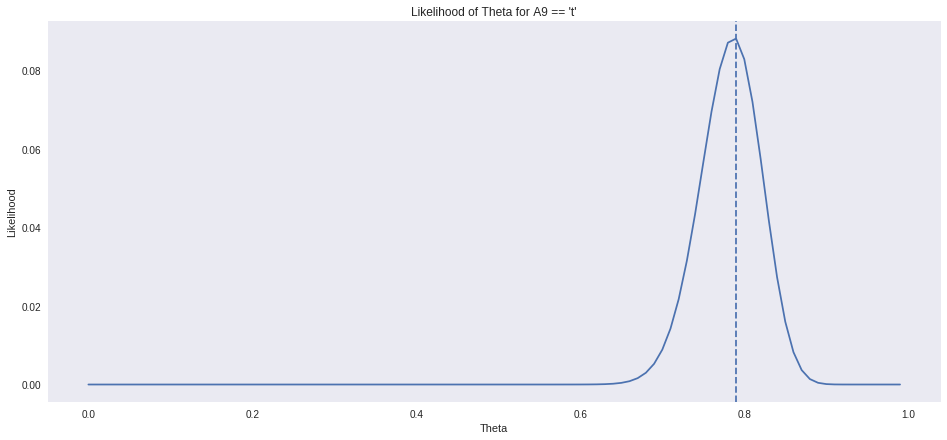

In [12]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 7)


def likelihood(theta, n, x):
    """
    likelihood function for a binomial distribution

    n: [int] the number of experiments
    x: [int] the number of successes
    theta: [float] the proposed probability of success
    """
    return (factorial(n) / (factorial(x) * factorial(n - x))) \
            * (theta ** x) * ((1 - theta) ** (n - x))


#the number of impressions for our facebook-yellow-dress campaignn_impressions = 10.
n_A9_true = df.A9[df.A9 == 't'].count()
#the number of clicks for our facebook-yellow-dress campaign
accepted = df.A16[(df.A9 == 't') & (df.A16 == '+')].count()
#observed click through rate
ctr = accepted / n_A9_true
# print(f"ctr {ctr} A10 count {df.A10[df.A10 == 't'].count()}  A16 accepted {df.A16[(df.A10 == 't') & (df.A16 == '+')].count()}")
#0 to 1, all possible click through rates
possible_theta_values = list(np.linspace(0, .99, 100))

scale = 3
n_A9_true /= scale
accepted /= scale

likelihoods = [
    likelihood(theta, n_A9_true, accepted) for theta in possible_theta_values
]
# #pick the best theta
mle = possible_theta_values[np.argmax(likelihoods)]
print(f'most likely theta {mle}')
#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.axvline(mle, linestyle="--")
ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid()
ax.set_title("Likelihood of Theta for A9 == 't'")
plt.show()

columns A9, A10 and A11 are the strongest indicators of A16 == '+' acceptance with A9 being slightly strongest 